In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim

#from envs.environments import NeuralNetwork

In [2]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size, fc1_unit=None, fc2_unit=None):
        super(NeuralNetwork, self).__init__()
        if fc1_unit is None:
            self.big = False
            self.fc1 = nn.Linear(input_size, 64)
            self.fc2 = nn.Linear(64, output_size)
        else:
            self.big = True
            self.fc1 = nn.Linear(input_size, fc1_unit)
            self.fc2 = nn.Linear(fc1_unit, fc2_unit)
            self.fc3 = nn.Linear(fc2_unit, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))

        if not self.big:
            x = self.fc2(x)
        else:
            x = torch.relu(self.fc2(x))
            x = self.fc3(x)
        return x

In [3]:
def transition_generator(maze, with_walls = True):
    transiciones = []

    n_rows, n_cols = len(maze), len(maze[0])

    for y in range(n_rows):
        for x in range(n_cols):
            # Si la casilla actual es un muro o una casilla 'x' (forzada a no demostracion),
            # no se puede guardar la transición
            if maze[y][x] != '#' and maze[y][x] != 'x':
                for a in range(4):
                    if a == 0:  # Mover hacia el norte
                        y1, x1 = max(0, y - 1), x
                    elif a == 1:  # Mover hacia el sur
                        y1, x1 = min(n_rows - 1, y + 1), x
                    elif a == 2:  # Mover hacia el oeste
                        y1, x1 = y, max(0, x - 1)
                    elif a == 3:  # Mover hacia el este
                        y1, x1 = y, min(n_cols - 1, x + 1)

                    # Si la casilla siguiente es un muro y el booleano es válido,
                    # se debe guardar la transición de la casilla actual a sí misma
                    if maze[y1][x1] == '#':
                        if with_walls:
                            transiciones.append([y, x, a, y, x])
                    # Si la casilla siguiente es una casilla 'x' no vamos a guardar ninguna transición
                    elif maze[y1][x1] == 'x':
                        pass
                    # Si la siguiente no es ninguna de las anteriores, se guarda la transición
                    else:
                        transiciones.append([y, x, a, y1, x1])

    return transiciones

def transitions_families_generator_BASIC(transiciones_iniciales, porcentaje_retencion, n):
    n_transiciones_iniciales = len(transiciones_iniciales)
    m = int((1 - porcentaje_retencion) * n_transiciones_iniciales)

    nuevos_arrays = []

    for _ in range(n):
        # Crear una copia de las transiciones iniciales
        nuevas_transiciones = transiciones_iniciales.copy()

        # Eliminar aleatoriamente M transiciones
        transiciones_a_eliminar = random.sample(nuevas_transiciones, m)
        for t in transiciones_a_eliminar:
            nuevas_transiciones.remove(t)

        nuevos_arrays.append(nuevas_transiciones)

    return nuevos_arrays


# Misma función que la anterior pero con un porcentaje de retención fijo del 66%
# y que después genera el otro 33% de transiciones con repeticiones de las que ya tiene
# Al final tendrá el mismo numero de transiciones que la lista original
def transitions_families_generator_WITH_REPETITION(transiciones_iniciales, n):
    n_transiciones_iniciales = len(transiciones_iniciales)
    n_borradas = int((1 - 0.66) * n_transiciones_iniciales)
    
    nuevos_arrays = []

    for _ in range(n):
        # Crear una copia de las transiciones iniciales
        nuevas_transiciones = transiciones_iniciales.copy()

        # Eliminar aleatoriamente 'n_retenidas' transiciones
        transiciones_a_eliminar = random.sample(nuevas_transiciones, n_borradas)
        for t in transiciones_a_eliminar:
            nuevas_transiciones.remove(t)

        # Repetir aleatoriamente 'n_borradas' transiciones
        transiciones_a_repetir = random.sample(nuevas_transiciones, n_borradas)
        nuevas_transiciones.extend(transiciones_a_repetir)

        nuevos_arrays.append(nuevas_transiciones)

    return nuevos_arrays

In [ ]:
def transitions_families_generator_FULLY_REPRESENTED(transiciones_iniciales, n):
    n_transiciones_iniciales = len(transiciones_iniciales)
    n_subset = int(0.66 * n_transiciones_iniciales)

    nuevos_arrays = []

    for i in range(n):

        # Crear una copia de las transiciones iniciales
        nuevas_transiciones = transiciones_iniciales.copy()
        
        start_index = (i * n_subset) % len(nuevas_transiciones)
        end_index = (start_index + n_subset) % len(nuevas_transiciones)

        if start_index < end_index:
            nuevas_transiciones = nuevas_transiciones[start_index:end_index]
        else:
            nuevas_transiciones = nuevas_transiciones[start_index:] + nuevas_transiciones[:end_index]        

        # Repetir aleatoriamente 'n_borradas' transiciones
        transiciones_a_repetir = random.sample(nuevas_transiciones, n_transiciones_iniciales - n_subset)
        nuevas_transiciones.extend(transiciones_a_repetir)

        nuevos_arrays.append(nuevas_transiciones)

    return nuevos_arrays

In [ ]:

def count_original_transitions(all_transitions, new_transitions):
    # Aplanar la lista de sublistas
    flattened_new_transitions = [item for sublist in new_transitions for item in sublist]

    # Inicializar un diccionario para contar las transiciones originales
    counts = defaultdict(int)

    # Contar la frecuencia de cada transición original
    for transition in flattened_new_transitions:
        counts[tuple(transition)] += 1

    index = 1
    # Imprimir los resultados
    for original_transition in all_transitions:
        count = counts.get(tuple(original_transition), 0)
        print(f"{index} Transición: {original_transition}, Apariciones: {count}")
        index += 1

In [4]:
class FamiliaTransiciones:
    def __init__(self, id, shape, T):
        self.id = id
        self.shape = shape

        self.T = T
        
        self.sy_values = np.array([], dtype = np.float32)
        self.sx_values = np.array([], dtype = np.float32)
        self.a_values = np.array([], dtype = np.float32)
        self.sy1_values = np.array([], dtype = np.float32)
        self.sx1_values = np.array([], dtype = np.float32)

        self.input_data = None
        self.target_data = None

        self.X_train_tensor = None
        self.X_test_tensor = None
        self.y_train_tensor = None
        self.y_test_tensor = None

        if shape == "5x5":
            self.model = NeuralNetwork(3, 2)
            self.n_epochs = 5000
        elif shape == "14x14":
            self.model = NeuralNetwork(3, 2, 128, 64)
            self.n_epochs = 10000
        
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters())
        self.losses = []

        self.generate_arrays()
    

    def generate_arrays(self):
        for t in self.T:
            self.sy_values = np.append(self.sy_values, t[0])
            self.sx_values = np.append(self.sx_values, t[1])
            self.a_values = np.append(self.a_values, t[2])
            self.sy1_values = np.append(self.sy1_values, t[3])
            self.sx1_values = np.append(self.sx1_values, t[4])

        self.input_data = np.column_stack((self.sy_values, self.sx_values, self.a_values))
        self.target_data = np.column_stack((self.sy1_values, self.sx1_values))

    def train(self):
        X_train, X_test, y_train, y_test = train_test_split(self.input_data, self.target_data, test_size=0.05)
        
        self.X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        self.y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
        self.X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        self.y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

        for _ in range(self.n_epochs):
            # Forward pass
            outputs = self.model(self.X_train_tensor)
            loss = self.criterion(outputs, self.y_train_tensor)
            
            # Backpropagation and optimization
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            self.losses.append(loss.item())
        
        print("Trained successfully!")
        print(f'Final loss: {self.losses[-1]}\n')

        #save the model with info of the shape and the id
        torch.save(self.model.state_dict(), f'../data/offline_models/{self.shape}_{self.id}.pt')

    def test_loss(self):
        with torch.no_grad():
            test_outputs = self.model(self.X_test_tensor)
            test_loss = self.criterion(test_outputs, self.y_test_tensor)
            print(f'Test loss: {test_loss.item()}')

    def show_loss(self):
        plt.xlabel("# Epoch")
        plt.ylabel("Loss Magnitude")
        plt.plot(self.losses)
        plt.show()

In [5]:
maze5x5 = { "starting_pos": [[0,0], [2,0], [4,0]],
             "maze":[
                    ['x', 'x', '#', 'x', 'G'],#0            0
                    ['x', 'x', '#', 'x', '.'],#1            ↑
                    ['x', '.', '.', '.', '.'],#2         2 ← → 3
                    ['.', '.', '#', 'x', 'x'],#3            ↓
                    ['S', '.', '#', 'x', 'x'],#4            1
                    # 0    1    2    3    4
                    ]
        }

"""maze5x5 = { "starting_pos": [[0,0], [2,0], [4,0]],
             "maze":[
                    ['x', 'x', '#', '#', 'x', '.', '.', 'G'],#0
                    ['x', 'x', '#', '#', 'x', '.', '.', 'x'],#1
                    ['x', 'x', '#', '#', 'x', 'x', '.', '.'],#2
                    ['x', '.', '.', '.', '.', 'x', 'x', '.'],#3
                    ['x', '.', '.', '#', '.', 'x', 'x', '.'],#4
                    ['x', '.', '.', '#', '.', '.', '.', '.'],#5
                    ['.', '.', '#', '#', '#', 'x', 'x', 'x'],#6
                    ['S', '.', '#', '#', '#', 'x', 'x', 'x'],#7
                    # 0    1    2    3    4    5    6    7
                    ]
        }"""

maze14x14 = { "starting_pos": [[0,0], [5,0], [7,0], [13,0], [13,5], [13,8], [13,11]],
             "maze":[
                    ['x', '#', 'x', 'x', '.', '.', '.', '.', '#', '#', '#', '#', '.', 'G'],#0
                    ['x', '#', 'x', '#', '#', '#', '.', '.', '.', 'x', 'x', 'x', '.', '.'],#1
                    ['x', 'x', 'x', 'x', '.', '#', '.', '.', '#', 'x', 'x', '#', '.', '.'],#2
                    ['x', '#', '#', '#', '.', '#', '.', '.', '.', 'x', 'x', '#', '.', '.'],#3
                    ['x', 'x', '#', 'x', '.', '#', '#', '#', '#', '#', '.', '#', '#', '.'],#4
                    ['x', 'x', 'x', 'x', '.', '.', '.', 'x', 'x', 'x', '.', '.', '#', '.'],#5
                    ['#', '#', '#', '#', '#', '.', '#', '#', 'x', 'x', '.', '.', '#', '.'],#6
                    ['.', '.', '.', '.', '#', '.', '.', '#', 'x', 'x', '.', '.', '.', '.'],#7
                    ['.', '.', '.', '.', '#', '.', '.', '#', '.', '#', '.', '#', '#', '#'],#8
                    ['#', '.', '#', '.', '#', '.', '#', '#', '.', '#', '.', '.', '.', '.'],#9
                    ['.', '.', '#', '.', '.', '.', '#', '.', '.', '.', '.', '.', '.', '.'],#10
                    ['.', '#', '#', 'x', '#', '.', '.', '.', '.', '#', '.', '#', '#', '.'],#11
                    ['.', 'x', 'x', 'x', '#', '#', '.', '#', '.', '#', '.', '.', '#', '.'],#12
                    ['S', 'x', '#', 'x', '#', '.', '.', '#', '.', '#', '.', '.', '#', '.'],#13
                    # 0    1    2    3    4    5    6    7    8    9   10   11   12   13
                    ]
            }

In [6]:
shape = "14x14"

if shape == "5x5":
    maze = maze5x5["maze"]
elif shape == "14x14":
    maze = maze14x14["maze"]

In [7]:
all_transitions = transition_generator(maze)

keep = 0.2  # Retener un % de las transiciones (0 a 1)

#Este siguiente parámetro debe ser impar para que haya menos posibilidades de empate
if shape == "5x5":
    n = 23  # Generar N nuevos arrays
elif shape == "14x14":
    n = 23


#new_transitions = transitions_families_generator(all_transitions, keep, n)

new_transitions = transitions_families_generator_66(all_transitions, n)

#print("Long. del array original:", len(all_transitions))

#for transitions in new_transitions:
    #print("Long. de nuevo array", len(transitions))
    #for i in range(5):
        #print(transitions[i])
    #print("-"*17)

In [8]:
families_arr = []

for i in range(len(new_transitions)):
    families_arr.append(FamiliaTransiciones(i, shape, new_transitions[i]))

"""for f in families_arr:
    print("sy_values: ", f.sy_values)
    print("sx_values: ", f.sx_values)
    print("a_values:  ", f.a_values)
    print("sy1_values:", f.sy1_values)
    print("sx1_values:", f.sx1_values)
    print("-" * 50 + "\n")"""

'for f in families_arr:\n    print("sy_values: ", f.sy_values)\n    print("sx_values: ", f.sx_values)\n    print("a_values:  ", f.a_values)\n    print("sy1_values:", f.sy1_values)\n    print("sx1_values:", f.sx1_values)\n    print("-" * 50 + "\n")'

In [10]:
for f in families_arr:
    print("Training model", f.id + 1, "/", len(families_arr))
    f.train()

Training model 1 / 23
Trained successfully!
Final loss: 0.035306017845869064

Training model 2 / 23
Trained successfully!
Final loss: 0.026715798303484917

Training model 3 / 23
Trained successfully!
Final loss: 0.03595741465687752

Training model 4 / 23
Trained successfully!
Final loss: 0.030286315828561783

Training model 5 / 23
Trained successfully!
Final loss: 0.034128621220588684

Training model 6 / 23
Trained successfully!
Final loss: 0.031264446675777435

Training model 7 / 23
Trained successfully!
Final loss: 0.029122259467840195

Training model 8 / 23
Trained successfully!
Final loss: 0.038525763899087906

Training model 9 / 23
Trained successfully!
Final loss: 0.04963803291320801

Training model 10 / 23
Trained successfully!
Final loss: 0.06536119431257248

Training model 11 / 23
Trained successfully!
Final loss: 0.04710500314831734

Training model 12 / 23
Trained successfully!
Final loss: 0.04066804051399231

Training model 13 / 23
Trained successfully!
Final loss: 0.0555098

Test loss: 0.08577648550271988


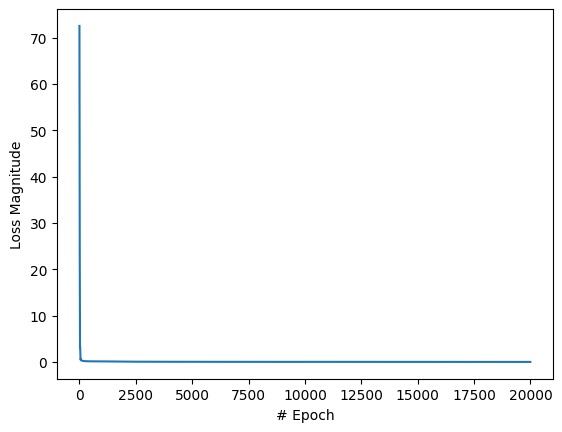

Test loss: 0.05106182396411896


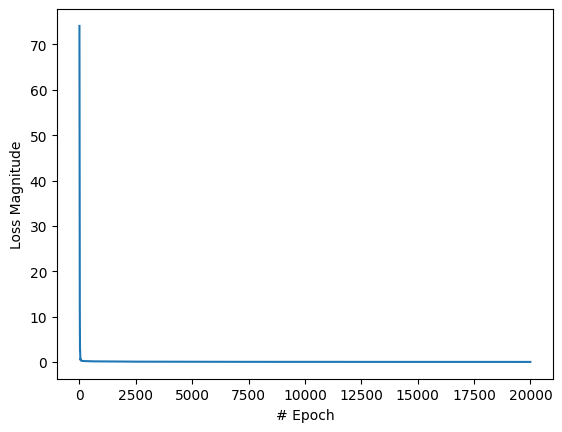

Test loss: 0.14568349719047546


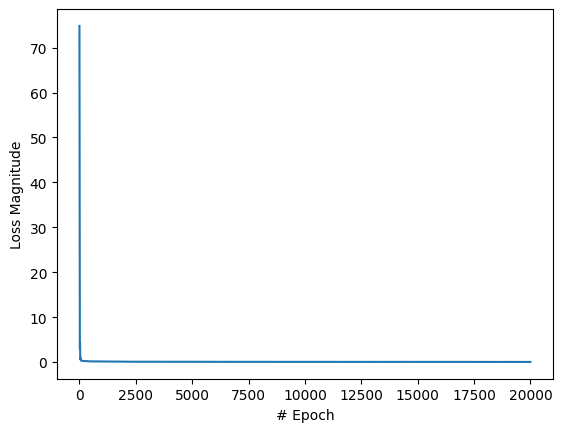

Test loss: 0.10407543182373047


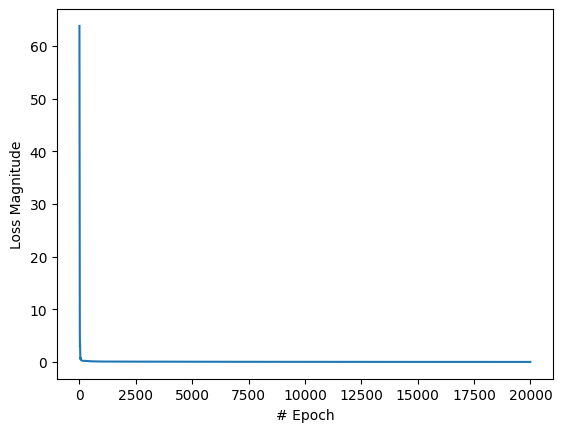

Test loss: 0.08006203174591064


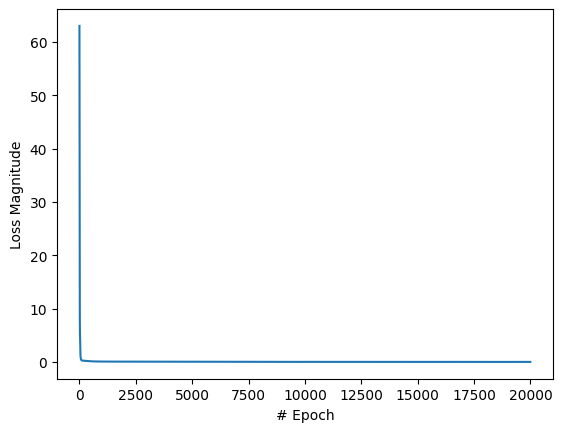

Test loss: 0.1514822095632553


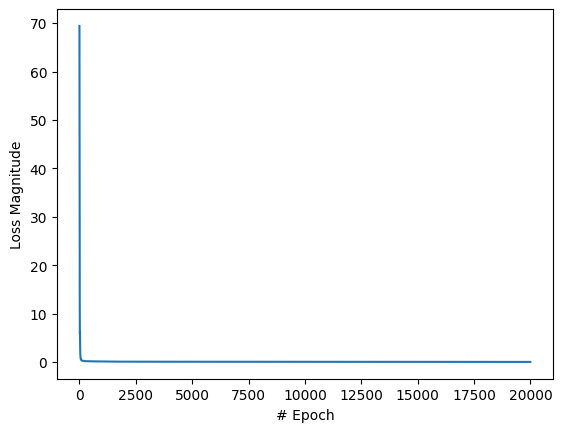

Test loss: 0.04853092133998871


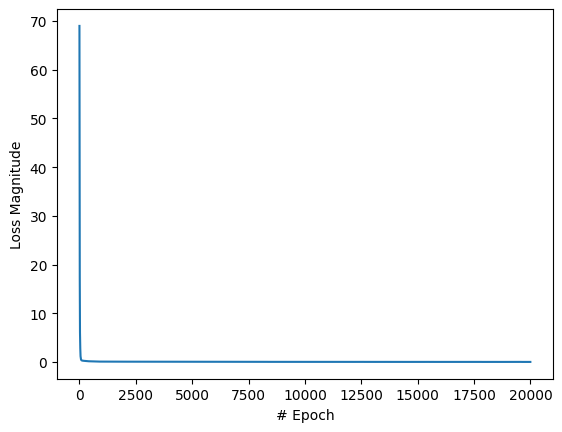

Test loss: 0.1061263382434845


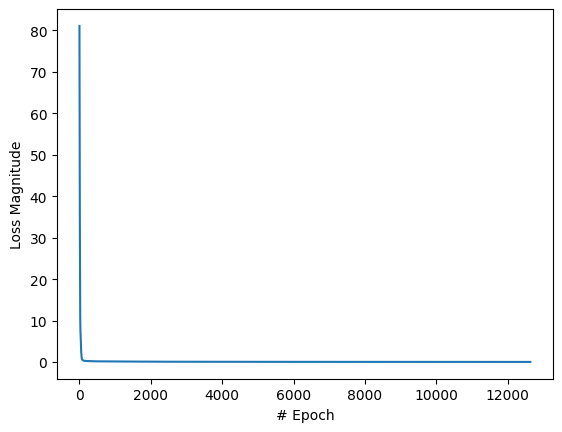

Test loss: 0.12251389026641846


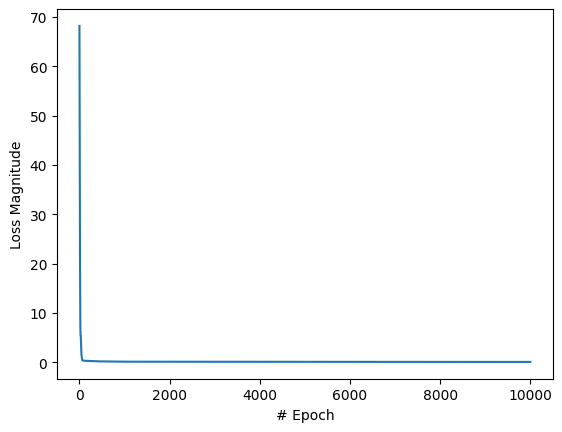

Test loss: 0.05742460489273071


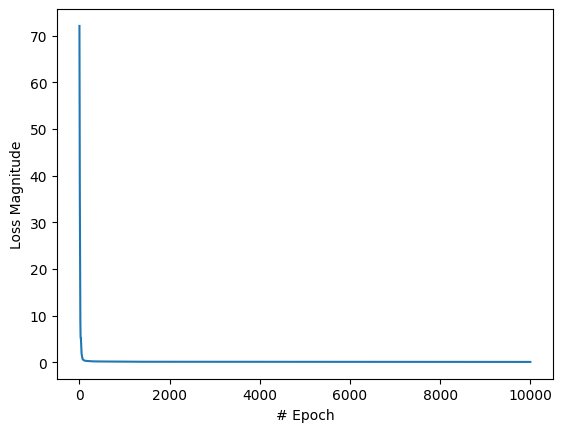

Test loss: 0.1308566778898239


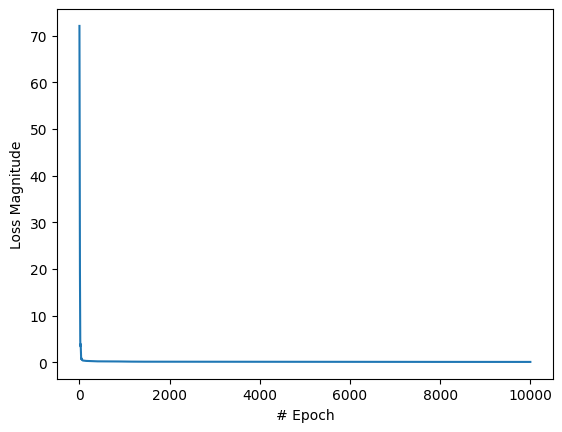

Test loss: 0.10903474688529968


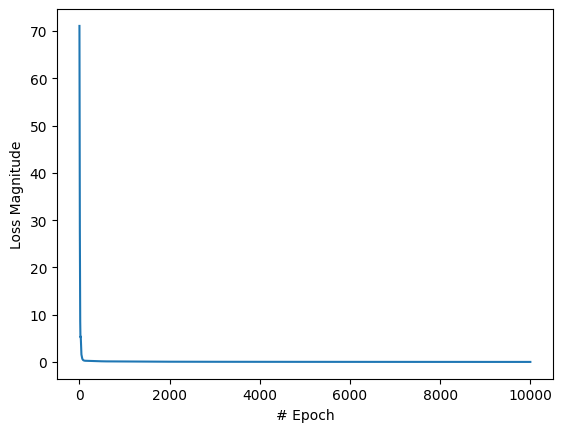

Test loss: 0.10879006236791611


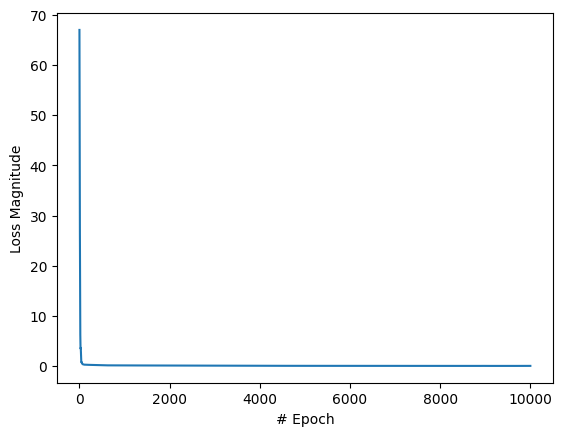

Test loss: 0.17774756252765656


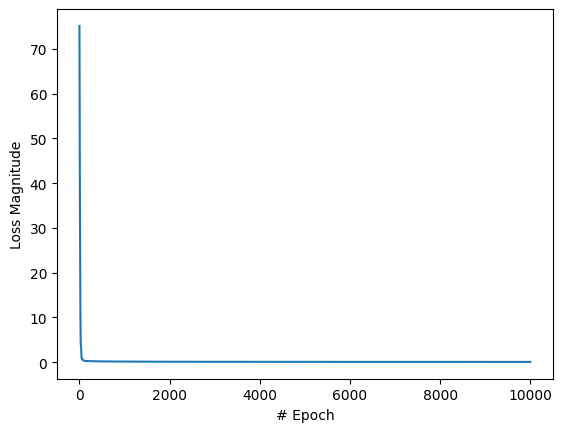

Test loss: 0.11684978008270264


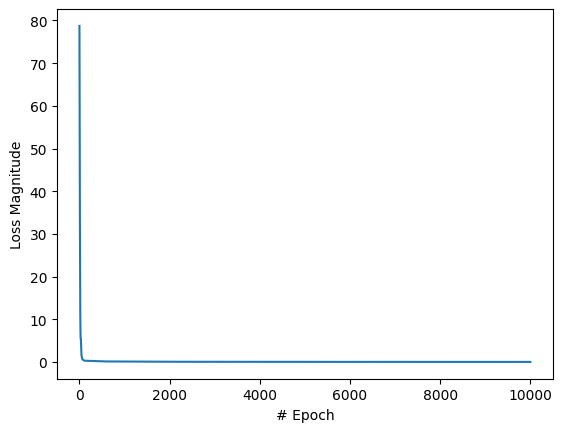

Test loss: 0.0994258001446724


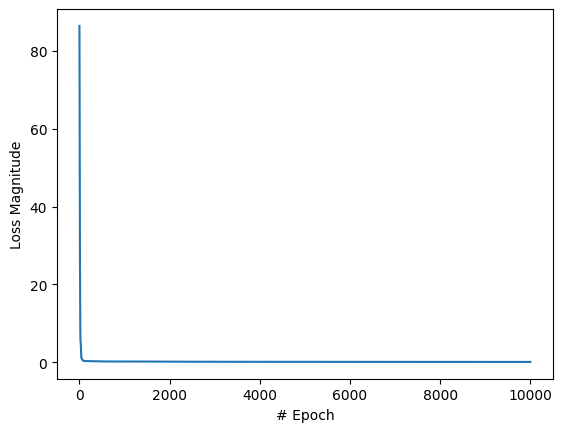

Test loss: 0.15542782843112946


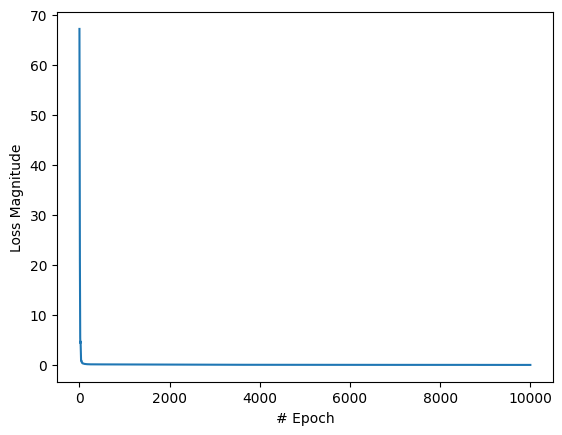

Test loss: 0.14493760466575623


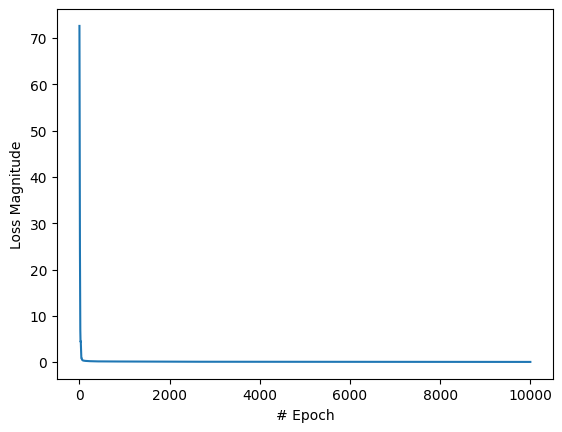

Test loss: 0.10072275996208191


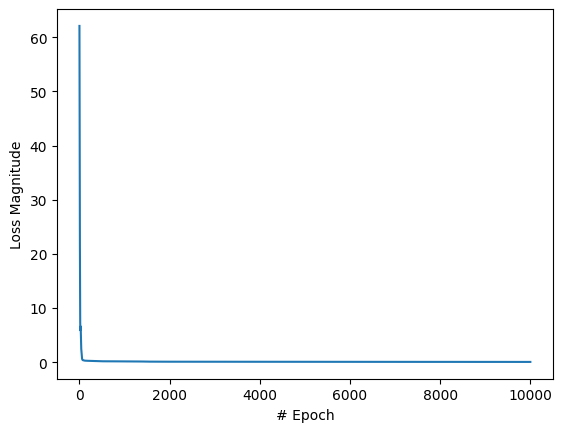

Test loss: 0.1496027112007141


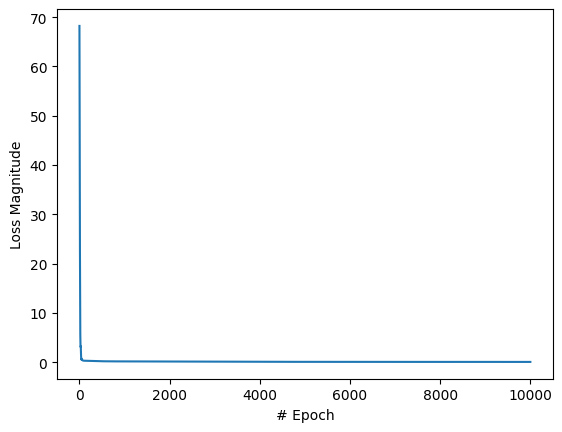

Test loss: 0.08895586431026459


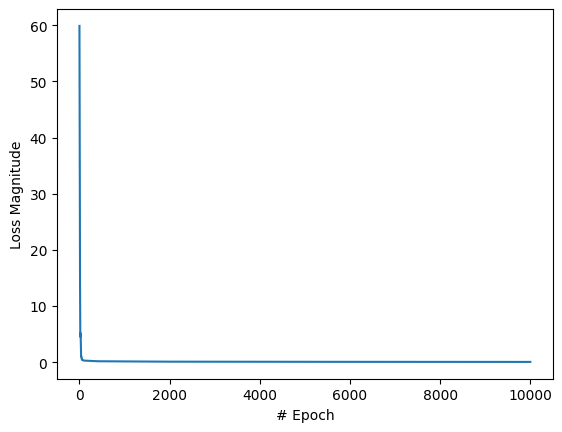

Test loss: 0.32588058710098267


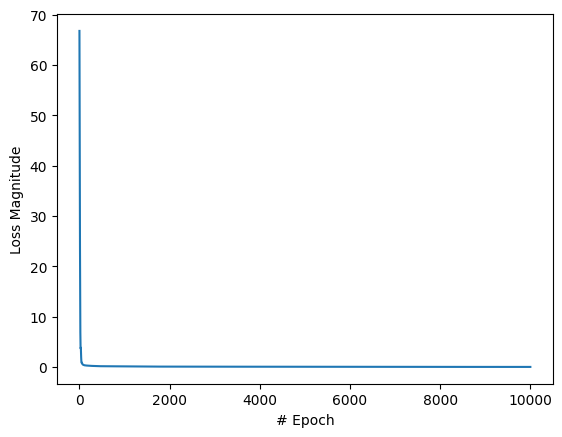

Test loss: 0.10133436322212219


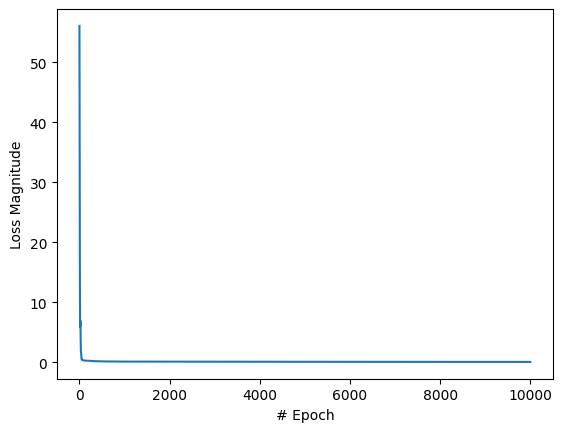

In [11]:
for f in families_arr:
    f.test_loss()
    #f.show_loss()

In [15]:
y, x = 12, 0

for i in range(4):
    posibilidades = []

    test_input = torch.tensor([[float(y), float(x), float(i)]], dtype=torch.float32)
    
    print("Input: " + str([y, x, i]))

    for i in range(len(families_arr)):
        resultado = families_arr[i].model(test_input)
        resultado = resultado.detach().numpy()
        posibilidades.append([round(resultado[0][0]), round(resultado[0][1])])
    
    #print("Estados futuros predichos: " + str(posibilidades))

    #Calculo el porcentaje de veces que aparece cada posibilidad
    probability_dict = {str(posibilidades.count(p)/len(posibilidades)*100) + "%": p for p in posibilidades}

    probability_dict = {}
    for p in posibilidades:
        if not str(p) in probability_dict:
            probability_dict[str(p)] = str(posibilidades.count(p)/len(posibilidades))


    print("Predicciones: ")
    for p in probability_dict:
        print(p + ": ", round(float(probability_dict[p])*100, 3),"%")

    #print("Probabilidad " + str(p) + ": " + str(posibilidades.count(p)/len(posibilidades)*100) + "%")
    
    print("--------------------------------------------------\n")

Input: [12, 0, 0]
Predicciones: 
[11, 0]:  100.0 %
--------------------------------------------------

Input: [12, 0, 1]
Predicciones: 
[13, 0]:  73.913 %
[12, 0]:  26.087 %
--------------------------------------------------

Input: [12, 0, 2]
Predicciones: 
[12, 0]:  100.0 %
--------------------------------------------------

Input: [12, 0, 3]
Predicciones: 
[12, 0]:  60.87 %
[12, 1]:  39.13 %
--------------------------------------------------



In [13]:
y, x = 2, 3

for i in range(4):
    posibilidades = []

    test_input = torch.tensor([[float(y), float(x), float(i)]], dtype=torch.float32)
    
    print("Input: " + str([y, x, i]))

    for i in range(len(families_arr)):
        resultado = families_arr[i].model(test_input)
        resultado = resultado.detach().numpy()
        posibilidades.append([round(resultado[0][0]), round(resultado[0][1])])
    
    #Calculo el porcentaje de veces que aparece cada posibilidad
    probability_dict = {str(posibilidades.count(p)/len(posibilidades)*100) + "%": p for p in posibilidades}

    probability_dict = {}
    for p in posibilidades:
        if not str(p) in probability_dict:
            probability_dict[str(p)] = str(posibilidades.count(p)/len(posibilidades))

    #Ordeno el diccionario por las probabilidades de mayor a menor
    probability_dict = {k: v for k, v in sorted(probability_dict.items(), key=lambda item: item[1], reverse=True)}
    
    highest_probability = list(probability_dict.keys())[0]
    #obtener el valor de la probabilidad del mas alto
    valor = float(list(probability_dict.values())[0])

    #convertirla de nuevo a lista
    highest_probability = highest_probability.replace("[", "").replace("]", "").split(", ")

    highest_probability = [highest_probability[0], highest_probability[1]]
    
    print("Predicciones: ")
    for p in probability_dict:
        print(p + ": ", round(float(probability_dict[p])*100, 3),"%")

    #print("Probabilidad " + str(p) + ": " + str(posibilidades.count(p)/len(posibilidades)*100) + "%")
    
    print("--------------------------------------------------\n")

Input: [2, 3, 0]
Predicciones: 
[2, 3]:  65.217 %
[1, 3]:  34.783 %
--------------------------------------------------

Input: [2, 3, 1]
Predicciones: 
[3, 3]:  47.826 %
[2, 3]:  30.435 %
[3, 2]:  8.696 %
[3, 4]:  4.348 %
[2, 2]:  4.348 %
[4, 3]:  4.348 %
--------------------------------------------------

Input: [2, 3, 2]
Predicciones: 
[2, 2]:  43.478 %
[2, 3]:  39.13 %
[1, 2]:  8.696 %
[1, 1]:  4.348 %
[3, 2]:  4.348 %
--------------------------------------------------

Input: [2, 3, 3]
Predicciones: 
[2, 3]:  39.13 %
[2, 4]:  26.087 %
[1, 3]:  13.043 %
[2, 6]:  4.348 %
[4, 2]:  4.348 %
[1, 4]:  4.348 %
[1, 2]:  4.348 %
[3, 5]:  4.348 %
--------------------------------------------------



In [14]:
"""#y, x = 2, 3
# Abre un archivo en modo de anexar ('a')
with open('archivo.txt', 'a') as archivo:
    #archivo.write("e")

    for fila in maze:
        for x in range(5):
            if fila[x] == 'x':
                y = maze.index(fila)
                print("y: ", y, "x: ", x)

                archivo.write("Casilla " + str(y) + ", " + str(x) + "\n")

                for i in range(4):
                    posibilidades = []

                    test_input = torch.tensor([[float(y), float(x), float(i)]], dtype=torch.float32)
                    
                    print("Input: " + str([y, x, i]))
                    archivo.write("Action: " + str(i) + "\n")
                    for i in range(len(families_arr)):
                        resultado = families_arr[i].model(test_input)
                        resultado = resultado.detach().numpy()
                        posibilidades.append([round(resultado[0][0]), round(resultado[0][1])])
                    
                    #Calculo el porcentaje de veces que aparece cada posibilidad
                    probability_dict = {str(posibilidades.count(p)/len(posibilidades)*100) + "%": p for p in posibilidades}

                    probability_dict = {}
                    for p in posibilidades:
                        if not str(p) in probability_dict:
                            probability_dict[str(p)] = str(posibilidades.count(p)/len(posibilidades))

                    #Ordeno el diccionario por las probabilidades de mayor a menor
                    probability_dict = {k: v for k, v in sorted(probability_dict.items(), key=lambda item: item[1], reverse=True)}
                    
                    highest_probability = list(probability_dict.keys())[0]
                    #obtener el valor de la probabilidad del mas alto
                    valor = float(list(probability_dict.values())[0])

                    #convertirla de nuevo a lista
                    highest_probability = highest_probability.replace("[", "").replace("]", "").split(", ")

                    highest_probability = [highest_probability[0], highest_probability[1]]
                    
                    archivo.write("Predicciones: ")
                    for p in probability_dict:
                        archivo.write(p + ": "+ str(round(float(probability_dict[p])*100, 3))+"%\n")

                    #print("Probabilidad " + str(p) + ": " + str(posibilidades.count(p)/len(posibilidades)*100) + "%")
                    
                    archivo.write("--------------------------------------------------\n")
                archivo.write("\n")"""

'#y, x = 2, 3\n# Abre un archivo en modo de anexar (\'a\')\nwith open(\'archivo.txt\', \'a\') as archivo:\n    #archivo.write("e")\n\n    for fila in maze:\n        for x in range(5):\n            if fila[x] == \'x\':\n                y = maze.index(fila)\n                print("y: ", y, "x: ", x)\n\n                archivo.write("Casilla " + str(y) + ", " + str(x) + "\n")\n\n                for i in range(4):\n                    posibilidades = []\n\n                    test_input = torch.tensor([[float(y), float(x), float(i)]], dtype=torch.float32)\n                    \n                    print("Input: " + str([y, x, i]))\n                    archivo.write("Action: " + str(i) + "\n")\n                    for i in range(len(families_arr)):\n                        resultado = families_arr[i].model(test_input)\n                        resultado = resultado.detach().numpy()\n                        posibilidades.append([round(resultado[0][0]), round(resultado[0][1])])\n              